<a href="https://colab.research.google.com/github/don-06don/MOOCs-ML-Model/blob/main/03.MOOCs_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📚We start by importing all necessary libraries for data manipulation, machine learning, and text embeddings.  
- `pandas` and `numpy` for data handling  

- `scikit-learn` for model training, scaling, and evaluation  

- `imblearn` for SMOTE (handling imbalanced datasets)  

- `sentence-transformers` for converting text into numerical embeddings

- `RandomForestClassifier` and `SVC` for classification  

- `matplotlib.pyplot` For plotting graphs

- `KMeans: For clustering` the features

- `silhouette_score` For evaluating clustering quality

We then mount Google Drive to access the dataset.

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from google.colab import drive
from IPython.display import display
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/MyDrive/moocs.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **✂️ Handle Missing Text & Merge Features**

- Drop rows where the "Text" column is missing, because the text is the main feature for our model.  
  If there is no text, the row is not useful for prediction.  
- We did **not** handle missing values in other columns (`post_type`, `CourseType`) because they are included in the "merged" column and will still contribute information even if they have missing values.  
- Merge `post_type`, `CourseType`, and `Text` into a single "merged" column.  
- This combined text column will be used for generating embeddings.

In [2]:
print('Shape before dealing with missing value in "Text":',df.shape) #no. of(rows,cols)

df = df.dropna(subset=["Text"])

print('Shape before merging:',df.shape) #no. of(rows,cols)

df["merged"] = df[["post_type", "CourseType", "Text"]].astype(str).agg(" ".join, axis=1)
print(df["merged"].head())

print('Shape after merging:',df.shape) #no. of(rows,cols)

Shape before dealing with missing value in "Text": (29604, 7)
Shape before merging: (29603, 7)
0    Comment Education Interesting! How often we sa...
1    Comment Education What is \Algebra as a Math G...
2    Comment Education I like the idea of my kids p...
3    CommentThread Education From their responses, ...
4    CommentThread Education The boys loved math, b...
Name: merged, dtype: object
Shape after merging: (29603, 8)


# **🎯 Binary Target Creation**

Convert the "Urgency(1-7)" column into a binary target:

0 → low urgency (<4)

1 → high urgency (>=4)
This simplifies the problem into a binary classification task.
Print the distribution before and after conversion to verify.

In [3]:
df["Urgency_binary"] = 0  #create new empty col.
for index, row in df.iterrows():   # Iterate over rows using iterrows()
    value = row["Urgency(1-7)"]  # Access the value using the row object
    if value < 4:
        df.loc[index, "Urgency_binary"] = 0  #.loc(row,cols) 3shan nwsl l df
    else:
        df.loc[index, "Urgency_binary"] = 1

print("Before: values in Urgency(1-7):", df["Urgency(1-7)"].unique()) #the old col.
print(df["Urgency(1-7)"].value_counts())

print("After: Unique values:", df["Urgency_binary"].unique()) #the new col.
print(df["Urgency_binary"].value_counts())

Before: values in Urgency(1-7): [1.5 3.5 2.5 3.  5.5 4.5 5.  1.  2.  6.5 4.  6.  7. ]
Urgency(1-7)
2.0    6427
2.5    4623
1.5    3946
1.0    3501
3.0    3308
5.0    2259
5.5    1990
3.5    1380
4.5     862
4.0     812
6.0     415
6.5      66
7.0      14
Name: count, dtype: int64
After: Unique values: [0 1]
Urgency_binary
0    23185
1     6418
Name: count, dtype: int64


# **📝 Prepare Data for Embeddings**

Keep only the "merged" column and the binary target for modeling.
Convert the text to a list for feeding into the sentence transformer model.

In [4]:
df_new = df[["merged", "Urgency_binary"]].copy()
display(df_new.head())

,merged,Urgency_binary
0,Comment Education Interesting! How often we sa...,0
1,Comment Education What is \Algebra as a Math G...,0
2,Comment Education I like the idea of my kids p...,0
3,"CommentThread Education From their responses, ...",0
4,"CommentThread Education The boys loved math, b...",0


In [5]:
!pip install sentence-transformers


# **🤖 Encode Text with Sentence Transformers**

We use the all-MiniLM-L6-v2 pre-trained model to generate embeddings from the merged text.

This model is lightweight yet powerful, making it ideal for handling short feedback and text data like ours.

Normalizing the embeddings helps improve performance in models such as SVC and Random Forest.

The embeddings effectively capture semantic meaning from the text, making them highly suitable for predicting urgency.

This choice of model is particularly good for feedback-type text, as it balances speed and accuracy.

In [6]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
texts = df_new["merged"].astype(str).tolist()

embeddings = model.encode(
    texts,
    batch_size=512,
    convert_to_numpy=True,
    normalize_embeddings=True,
    show_progress_bar=True
)

print("embeddings shape:", embeddings.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/58 [00:00<?, ?it/s]

embeddings shape: (29603, 384)


# **🔀 Train-Test Split & SMOTE**

Split data into training and testing sets with stratification to maintain class balance.
Apply SMOTE on the training set to balance the classes and reduce bias towards the majority class.
Print the distribution before and after SMOTE.

In [7]:
X = np.copy(embeddings)
y = df_new["Urgency_binary"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#Handle imbalanced data using SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_res))

Before SMOTE: [16229  4493]
After SMOTE: [16229 16229]


# **🌲 Random Forest Baseline**
Train a Random Forest classifier on the resampled training set.
Use class_weight='balanced' to further handle imbalance.
Evaluate accuracy and F1-score on the test set as a baseline for comparison.

In [8]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)

# Predict and evaluate
y_pred = rf.predict(X_test)
print("RandomForest Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

RandomForest Accuracy: 0.8263709041774575
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89      6956
           1       0.60      0.62      0.61      1925

    accuracy                           0.83      8881
   macro avg       0.74      0.75      0.75      8881
weighted avg       0.83      0.83      0.83      8881



# **📊Clustering Analysis with KMeans**
 applies **K-Means clustering** on embeddings to find the optimal number of clusters.




We use two evaluation methods:
- **Elbow Method** → based on inertia (sum of squared distances within clusters).  
- **Silhouette Method** → based on silhouette score (cluster separation quality).  

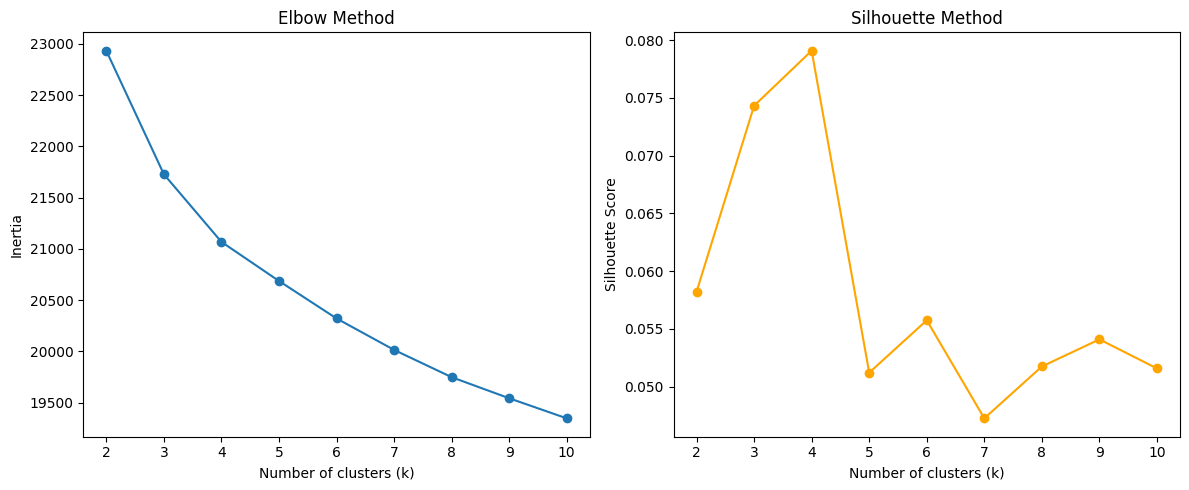

In [9]:
#Assume X is your feature matrix (embeddings)
X = np.copy(embeddings)
inertias = []           # To store inertia values for the Elbow method
silhouette_scores = []  # To store silhouette scores

K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)

    # Store inertia (sum of squared distances within clusters)
    inertias.append(kmeans.inertia_)

    # Compute silhouette score (measure of cluster quality)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(12,5))

# Elbow method plot (inertia vs. k)
plt.subplot(1,2,1)
plt.plot(K, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")

# Silhouette method plot (silhouette score vs. k)
plt.subplot(1,2,2)
plt.plot(K, silhouette_scores, marker='o', color='orange')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")

plt.tight_layout()
plt.show()